This is based on Gil's work: 
https://signal.onepointltd.com/post/102gc83/sentiment-analysis-with-yelp-and-bert
https://github.com/onepointconsulting/yelp_bert/blob/master/preprocess_data.ipynb

And on this one:
https://github.com/Sonull/Sentiment-Analysis-on-Yelp-Reviews/blob/master/RF_and_SVM1.ipynb

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from pathlib import Path
import json
import seaborn as sns
from collections import Counter
import re
from sklearn.model_selection import train_test_split

/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_checkin.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_business.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_tip.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_user.json
/kaggle/input/yelp-dataset/Dataset_Agreement.pdf


In [ ]:
#business_file = '/kaggle/input/yelp-dataset/yelp_academic_dataset_business.json'
#df_business.head(5)

In [2]:
review_file = '/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json'

In [3]:
sample_size = 40000 # I reduced the size of sample considerably
simplified_reviews = './yelp_reviews_simple_{sample_size}.json'

def extract_simplified(source, target, lines=1000):
    with open(target, 'w') as sr:
        cnt = 0;
        with open(source) as file:
            line = file.readline()
            while line:
                cnt += 1
                if cnt == lines:
                    break
                if cnt % 100_000 == 0:
                    print(f'Processed {cnt}')
                try:
                    line = file.readline().strip()
                    review_dict = json.loads(line)
                    simplified = {'text':  review_dict['text'], 'stars': review_dict['stars']}
                    simplified_text = json.dumps(simplified)
                    sr.write(f'{simplified_text}\n')
                except:
                    print(f'Could not parse {line}')
                    
extract_simplified(review_file, simplified_reviews, lines=sample_size)

In [4]:
simplified_reviews_pd = pd.read_json(simplified_reviews, lines=True)

In [5]:
simplified_reviews_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39999 entries, 0 to 39998
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    39999 non-null  object
 1   stars   39999 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [6]:
simplified_reviews_pd

,text,stars
0,I am actually horrified this place is still in...,1
1,I love Deagan's. I do. I really do. The atmosp...,5
2,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",1
3,"Oh happy day, finally have a Canes near my cas...",4
4,This is definitely my favorite fast food sub s...,5
...,...,...
39994,We stopped here after reading a Yelp review. A...,5
39995,I love this cafe! Doesn't matter what day it i...,5
39996,Finally after months of waiting the hubby and ...,5
39997,I always wanted to try a blowout service but a...,1


In [7]:
simplified_reviews_pd['stars'].value_counts()

5    17495
4     9218
1     5593
3     4445
2     3248
Name: stars, dtype: int64

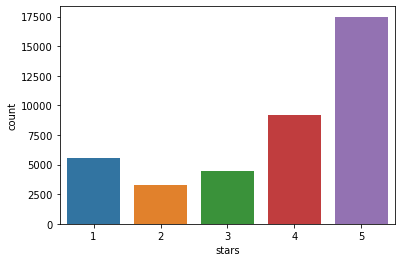

In [8]:
sns.countplot(simplified_reviews_pd['stars'])

In [9]:
# EXPLAIN
counter_star = Counter(simplified_reviews_pd['stars'])

In [10]:
# EXPLAIN
min_class = -1
min_amount = 1000000000
for cs in counter_star:
    if min_amount > counter_star[cs]:
        min_amount = counter_star[cs]
        min_class = cs
min_class, min_amount

(2, 3248)

In [11]:
remove_amounts = {c: abs(min_amount - counter_star[c]) for c in counter_star}
remove_amounts

{1: 2345, 5: 14247, 4: 5970, 3: 1197, 2: 0}

In [12]:
remove_amounts[1] -= 1
remove_amounts

{1: 2344, 5: 14247, 4: 5970, 3: 1197, 2: 0}

In [13]:
%%time
drop_indices = []
for index, row in simplified_reviews_pd.iterrows():
    if remove_amounts[row['stars']] > 0:
        remove_amounts[row['stars']] -= 1
        drop_indices.append(index)
len(drop_indices)

CPU times: user 3.51 s, sys: 0 ns, total: 3.51 s
Wall time: 3.52 s


23758

In [65]:
balanced_simplified_reviews = simplified_reviews_pd.drop(drop_indices)

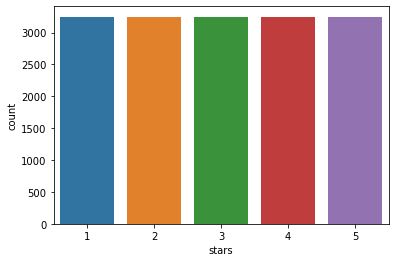

In [66]:
sns.countplot(balanced_simplified_reviews['stars'])

In [67]:
balanced_simplified_reviews['stars'].unique()

array([2, 3, 1, 4, 5])

In [68]:
# dropping reviews with 3 stars
balanced_simplified_reviews.drop(balanced_simplified_reviews.index[balanced_simplified_reviews['stars'] == 3], inplace = True)
print('yelp_reviews labels: ' + str(balanced_simplified_reviews.stars.unique()))
print('yelp_reviews shape: ' + str(balanced_simplified_reviews.shape))


yelp_reviews labels: [2 1 4 5]
yelp_reviews shape: (12993, 2)


In [69]:
# changing to only 2 labels: 0=negative, 1=positive
balanced_simplified_reviews['label'] = balanced_simplified_reviews['stars'].replace({1:0,2:0,4:1,5:1})

In [70]:
balanced_simplified_reviews['stars'].value_counts()

1    3249
5    3248
4    3248
2    3248
Name: stars, dtype: int64

In [71]:
balanced_simplified_reviews.head()

,text,stars,label
31,This actually used to be one of my favorite ho...,2,0
62,Decent food. Fishermen lobster or even congee ...,2,0
77,"Pros: Fun atmosphere, great for people watchin...",2,0
85,"I love bookstores, and I love to spend some ti...",2,0
86,"I passed Five Guys, In-N-Out, Carl's Jr, and S...",2,0


In [72]:
balanced_simplified_reviews.drop('stars',inplace=True,axis = 1)

## Cleaning the reviews

In [23]:
from gensim.parsing.preprocessing import STOPWORDS, strip_tags, strip_numeric, strip_punctuation, strip_multiple_whitespaces, remove_stopwords, strip_short, stem_text
from nltk.corpus import stopwords
import re

In [73]:
for r in balanced_simplified_reviews:
    balanced_simplified_reviews['text'] = balanced_simplified_reviews['text'].apply(lambda t: strip_numeric(t))
    balanced_simplified_reviews['text'] = balanced_simplified_reviews['text'].apply(lambda t: strip_punctuation(t))
    balanced_simplified_reviews['text'] = balanced_simplified_reviews['text'].apply(lambda t: strip_multiple_whitespaces(t))
    balanced_simplified_reviews['text'] = balanced_simplified_reviews['text'].apply(lambda t: t.lower())
    #balanced_simplified_reviews['text'] = balanced_simplified_reviews['text'].apply(lambda t: remove_stopwords(t))
    #balanced_simplified_reviews['text'] = balanced_simplified_reviews['text'].apply(lambda t: strip_short(t))

In [74]:
balanced_simplified_reviews.head()

,text,label
31,this actually used to be one of my favorite ho...,0
62,decent food fishermen lobster or even congee q...,0
77,pros fun atmosphere great for people watching ...,0
85,i love bookstores and i love to spend some tim...,0
86,i passed five guys in n out carl s jr and soni...,0


In [36]:
# without stopwords and short
balanced_simplified_reviews.head()

,text,label
31,actually favorite hotel casinos day things cha...,0
62,decent food fishermen lobster congee queen bet...,0
77,pros fun atmosphere great people watching mech...,0
85,love bookstores love spend time browsing flipp...,0
86,passed guys carl sonic habit won happen know s...,0


In [ ]:
balanced_simplified_reviews.drop(labels='length', axis=1)

In [77]:
sample_balanced_reviews = balanced_simplified_reviews.drop(labels='length', axis=1)
sample_balanced_reviews = sample_balanced_reviews.reset_index(drop=True)
sample_balanced_reviews

,text,label
0,this actually used to be one of my favorite ho...,0
1,decent food fishermen lobster or even congee q...,0
2,pros fun atmosphere great for people watching ...,0
3,i love bookstores and i love to spend some tim...,0
4,i passed five guys in n out carl s jr and soni...,0
...,...,...
12988,we stopped here after reading a yelp review at...,1
12989,i love this cafe doesn t matter what day it is...,1
12990,finally after months of waiting the hubby and ...,1
12991,i always wanted to try a blowout service but a...,0


In [78]:
# including stopwords and short ones
sample_balanced_reviews.to_pickle('./sample_yelp_reviews_cleaned.pkl')

**Splitting into train, test and validation sets**

In [80]:
RANDOM_SEED = 42
sample_train, sample_test = train_test_split(sample_balanced_reviews, test_size=0.20, random_state=RANDOM_SEED, 
                                     stratify=sample_balanced_reviews.label.values)
sample_validation, sample_test = train_test_split(sample_test, test_size=0.25, random_state=RANDOM_SEED, stratify=sample_test.label.values)
sample_train.shape, sample_test.shape, sample_validation.shape

((10394, 2), (650, 2), (1949, 2))

In [ ]:
# including stopwords and short ones
sample_train.to_pickle('./sample_train_10394.pkl')
sample_validation.to_pickle('./sample_validation_1949.pkl')
sample_test.to_pickle('./sample_test_650.pkl')

In [81]:
train_df = sample_train.copy()
validation_df = sample_validation.copy()
test_df = sample_test.copy()

## EDA

In [42]:
# without stopwords and short
#CREATING A NEW COLUMN IN THE DATASET FOR THE NUMBER OF WORDS IN THE REVIEW
balanced_simplified_reviews['length'] = balanced_simplified_reviews['text'].apply(lambda x : len(x.strip().split(" ")))
balanced_simplified_reviews['length'].describe()

count    12993.000000
mean        47.742708
std         42.106026
min          1.000000
25%         20.000000
50%         34.000000
75%         61.000000
max        396.000000
Name: length, dtype: float64

In [75]:
# including stopwords and short ones
#CREATING A NEW COLUMN IN THE DATASET FOR THE NUMBER OF WORDS IN THE REVIEW
balanced_simplified_reviews['length'] = balanced_simplified_reviews['text'].apply(lambda x : len(x.strip().split(" ")))
balanced_simplified_reviews['length'].describe()

count    12993.000000
mean       116.031709
std        106.680525
min          1.000000
25%         46.000000
50%         82.000000
75%        150.000000
max       1005.000000
Name: length, dtype: float64

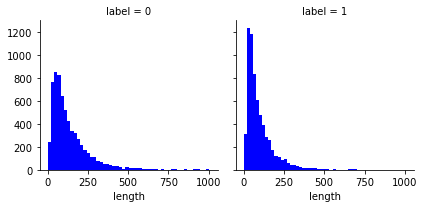

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
# COMPARING TEXT LENGTH TO STARS
graph = sns.FacetGrid(data=balanced_simplified_reviews,col='label')
graph.map(plt.hist,'length',bins=50,color='blue')
# 0 negative, 1 positive

**Confirming that thse subsets have the same distribution**

In [82]:
#CREATING A NEW COLUMN IN THE DATASET FOR THE NUMBER OF WORDS IN THE REVIEW
train_df['length'] = train_df['text'].apply(lambda x : len(x.strip().split(" ")))
train_df['length'].describe()

count    10394.000000
mean       115.930056
std        105.518930
min          1.000000
25%         46.000000
50%         83.000000
75%        150.000000
max       1005.000000
Name: length, dtype: float64

In [83]:
train_df.head()

,text,label,length
11349,second best pool in las vegas pay the commit t...,1,85
12582,we went there on a tuesday night in jan the we...,0,147
4547,my experience duplicates all other above below...,0,40
11873,mmmmmmr sushi this was the place i lost my sus...,1,124
12416,it is a little off the strip but they provide ...,1,57


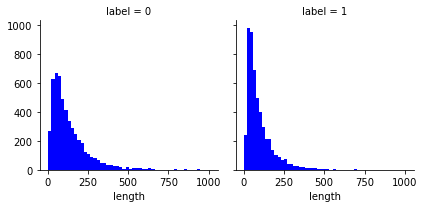

In [84]:
# COMPARING TEXT LENGTH TO STARS
graph = sns.FacetGrid(data=train_df,col='label')
graph.map(plt.hist,'length',bins=50,color='blue')
# 0 negative, 1 positive

In [85]:
validation_df['length'] = validation_df['text'].apply(lambda x : len(x.strip().split(" ")))
validation_df['length'].describe()

count    1949.000000
mean      116.552078
std       109.800608
min         1.000000
25%        45.000000
50%        80.000000
75%       148.000000
max       992.000000
Name: length, dtype: float64

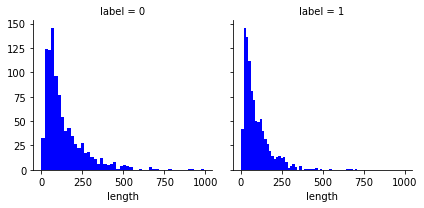

In [86]:
# COMPARING TEXT LENGTH TO STARS
graph = sns.FacetGrid(data=validation_df,col='label')
graph.map(plt.hist,'length',bins=50,color='blue')

In [87]:
test_df['length'] = test_df['text'].apply(lambda x : len(x.strip().split(" ")))
test_df['length'].describe()

count    650.000000
mean     116.096923
std      115.476056
min        8.000000
25%       44.000000
50%       79.000000
75%      146.000000
max      942.000000
Name: length, dtype: float64

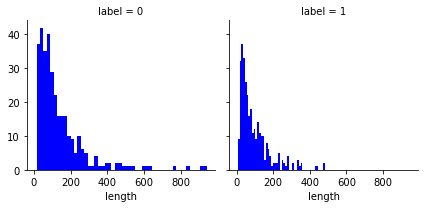

In [88]:
# COMPARING TEXT LENGTH TO STARS
graph = sns.FacetGrid(data=test_df,col='label')
graph.map(plt.hist,'length',bins=50,color='blue')